# Download Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# create directory for kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# dowload dataset
!kaggle datasets download -d deadskull7/fer2013

 96% 93.0M/96.6M [00:03<00:00, 22.8MB/s]
100% 96.6M/96.6M [00:03<00:00, 30.9MB/s]


In [5]:
# unzip dataset
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

# Import Libraries

In [6]:
# Import libraries
import csv
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from collections import defaultdict
from numpy.random import seed
seed(1)
%matplotlib inline

In [7]:
# dataset
data_path = '/content/files/fer2013.csv'

In [8]:
data = pd.read_csv(data_path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
data['emotion'].value_counts(normalize=True)

3    0.250481
6    0.172709
4    0.169337
2    0.142698
0    0.138017
5    0.111517
1    0.015242
Name: emotion, dtype: float64

In [10]:
import seaborn as sns

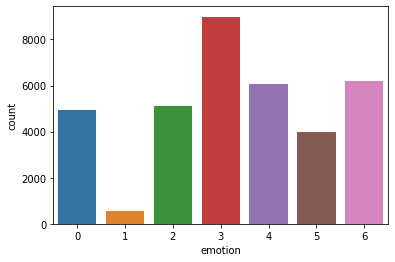

In [11]:
sns.countplot(data['emotion'])

In [12]:
#Upsample data
from sklearn.utils import resample
df_minority = data[data['emotion']==1]
df_majority = data[data['emotion']!=1]

In [13]:
df_minority_upsampled = resample(df_minority,
                              replace=True,
                              n_samples=3000,
                              random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [14]:
df_upsampled.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


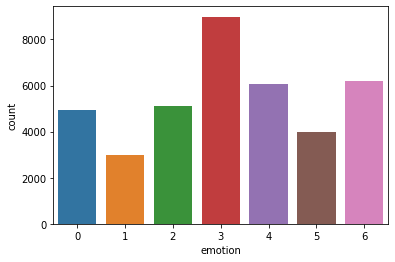

In [15]:
sns.countplot(df_upsampled['emotion'])

In [16]:
df_upsampled.to_csv('Balanced_data.csv', index=False)

# Dataset class

In [17]:
class FacialEmotionDataset(Dataset):
    
    def __init__(self, images=None, emotions=None, transform=None):
        self.images = images
        self.emotions = emotions
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion
    

class DatasetFactory:
    
    def __init__(self):
        self.images = []
        self.emotions = []
        self.val_images = []
        self.val_emotions = []
        self.test_images = []
        self.test_emotions = []
        
        with open('/content/Balanced_data.csv', 'r') as file:
            data = csv.reader(file)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype(np.uint8)
                
                if row[-1] == 'Training':
                    self.images.append(Image.fromarray(face))
                    self.emotions.append(int(row[0]))
                
                if row[-1] == 'PrivateTest':
                    self.val_images.append(Image.fromarray(face))
                    self.val_emotions.append(int(row[0]))
                    
                if row[-1] == 'PublicTest':
                    self.test_images.append(Image.fromarray(face))
                    self.test_emotions.append(int(row[0]))
                
        print(f'Training size: {len(self.images)}, \nTest size: {len(self.test_images)},\nValidation size: {len(self.val_images)}')

# Augumentation

In [18]:
train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor()
                                ])
 
val_transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

# Load Dataset

In [19]:
factory = DatasetFactory() 

training = FacialEmotionDataset(factory.images, factory.emotions, train_transform)
validation = FacialEmotionDataset(factory.val_images, factory.val_emotions, val_transform)
testing = FacialEmotionDataset(factory.test_images, factory.test_emotions, val_transform)

Training size: 30671, 
Test size: 3836,
Validation size: 3833


# DataLoader

In [20]:
train_loader = DataLoader(training, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing, batch_size=32)

# Image Visualization

images.shape:  torch.Size([64, 1, 48, 48])


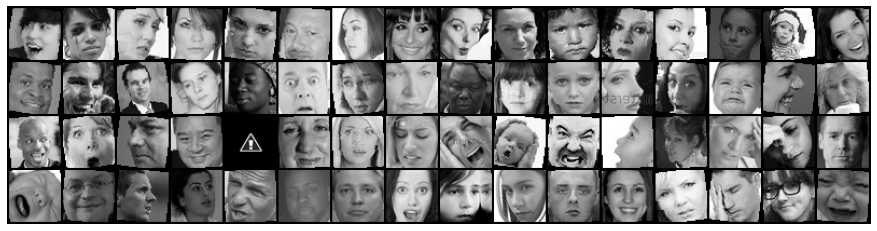

In [21]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# Model

In [22]:
class FacialEmotions(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1, bias=False)
    self.norm1 = nn.BatchNorm2d(16, affine=True, momentum=0.9, eps=1e-2)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, bias=False)
    self.norm2 = nn.BatchNorm2d(32, momentum=0.9, eps=1e-2)
    self.conv3 = nn.Conv2d(32, 64, 1, 2, 1, bias=False)
    self.norm3 = nn.BatchNorm2d(64, momentum=0.9, eps=1e-2)
    self.conv4 = nn.Conv2d(64, 128, 2, 1, 1, bias=False)
    self.norm4 = nn.BatchNorm2d(128, momentum=0.9, eps=1e-2)
    self.maxpool = nn.MaxPool2d(3, 2, 1)
    self.fc1 = nn.Linear(3*3*128, 5000)
    self.norm5 = nn.BatchNorm1d(5000, momentum=0.9, eps=1e-2)
    self.fc2 = nn.Linear(5000, 10000)
    self.norm6 = nn.BatchNorm1d(10000, momentum=0.9, eps=1e-2)
    self.fc3 = nn.Linear(10000, 1000)
    self.norm7 = nn.BatchNorm1d(1000, momentum=0.9, eps=1e-2)
    self.out = nn.Linear(1000, 7)

  def forward(self, x):
    x = self.norm1(F.relu(self.maxpool(self.conv1(x.float()))))
    x = self.norm2(F.relu(self.maxpool(self.conv2(x))))
    x = self.norm3(F.relu(self.maxpool(self.conv3(x))))
    x = self.norm4(F.relu(self.maxpool(self.conv4(x))))
    x = x.view(x.shape[0], -1)
    x = self.norm5(F.relu(self.fc1(x)))
    x = self.norm6(F.relu(self.fc2(x)))
    x = self.norm7(F.relu(self.fc3(x)))
    x = F.relu(self.out(x))
    return F.log_softmax(x, dim=1)

In [23]:
torch.cuda.empty_cache()
# instantiate Model
model = FacialEmotions()
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,9], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [25]:
def train(model, optimizer, criterion, data_loader): #scheduler
  running_correct = 0.0
  running_loss = 0.0

  for data, label in data_loader:
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
      data, label = data.cuda(), label.cuda()
    
    optimizer.zero_grad()
    model = model.train()
    output = model(data)
    loss = criterion(output, label)
    preds = output.data.max(dim=1, keepdim=True)[1]
    running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
    running_loss += criterion(output, label).item()

    loss.backward()
    optimizer.step()
    # scheduler.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'training loss is {loss:{5}.{2}} and training accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy


def validate(model, criterion, data_loader):
  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, label in data_loader:
      torch.cuda.empty_cache()
      if torch.cuda.is_available():
        data, label = data.cuda(), label.cuda()
      model = model.eval()
      output = model(data)
      loss = criterion(output, label)
      preds = output.data.max(dim=1, keepdim=True)[1]
      running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
      running_loss += criterion(output, label).item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy
    

In [ ]:
epochs = 20
history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader) #scheduler
    val_loss, val_accuracy = validate(model, criterion, validation_loader)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
training loss is 0.028 and training accuracy is   9251.0/(30671     30.16
validation loss is 0.028 and validation accuracy is   1326.0/(3833     34.59
Epoch 2/20
training loss is 0.025 and training accuracy is   12503.0/(30671     40.76
validation loss is 0.025 and validation accuracy is   1559.0/(3833     40.67
Epoch 3/20
training loss is 0.023 and training accuracy is   13889.0/(30671     45.28
validation loss is 0.026 and validation accuracy is   1470.0/(3833     38.35
Epoch 4/20
training loss is 0.022 and training accuracy is   14935.0/(30671     48.69
validation loss is 0.023 and validation accuracy is   1720.0/(3833     44.87
Epoch 5/20
training loss is 0.021 and training accuracy is   15838.0/(30671     51.64
validation loss is 0.025 and validation accuracy is   1663.0/(3833     43.39
Epoch 6/20
training loss is  0.02 and training accuracy is   16564.0/(30671     54.01
validation loss is 0.023 and validation accuracy is   1860.0/(3833     48.53
Epoch 7/20
training los

In [ ]:
def test(model, criterion, data_loader):
  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, label in data_loader:
      torch.cuda.empty_cache()
      if torch.cuda.is_available():
        data, label = data.cuda(), label.cuda()
      model = model.eval()
      output = model(data)
      loss = criterion(output, label)
      preds = output.data.max(dim=1, keepdim=True)[1]
      running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
      running_loss += criterion(output, label).item()

  loss = running_loss / len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)

  return loss, accuracy
    

In [ ]:
test(model, criterion, testing_loader)

(0.05327667076843747, tensor(50.0521))

In [ ]:
torch.save(model.state_dict(), '/content/fer.pt')